In [1]:
!pip install underthesea
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
import underthesea
import numpy as np
import matplotlib.pyplot as plt
from underthesea.pipeline import word_tokenize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 33.3 MB/s 
     |████████████████████████████████| 235 kB 72.5 MB/s 
     |████████████████████████████████| 581 kB 60.8 MB/s 
     |████████████████████████████████| 965 kB 54.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
url = "/content/drive/MyDrive/2021-2022/NLP/Data/Data_comment3.xlsx"
data = pd.read_excel(url, names=["Label","Data"])
data.head()

,Label,Data
0,4,giá cả rẻ
1,3,mức giá ở đây khá cao
2,7,mình thấy nhân viên khá nhiệt tình bạn nào cũn...
3,4,giá hợp lý
4,5,rau và nước chấm các loại đựng riêng trong túi...


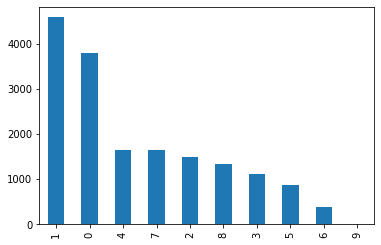

In [6]:
data['Label'].value_counts().plot.bar()

In [7]:
len(data['Label'])

16873

In [8]:
dataset = np.array(data)
np.random.shuffle(dataset)
dataset[:5]

array([[3, 'đồ ăn tráng miệng còn mắc nữa'],
       [7,
        'nhân viên khá nhanh nhẹn đồ ăn lên nhanh không phải chờ quá lâu'],
       [0,
        'bánh bao cà chua mình thấy bình thường không hợp khẩu vị mình lắm'],
       [2, 'quá tệ'],
       [2, 'đồ ăn thất vọng quá']], dtype=object)

In [9]:
df = pd.DataFrame (dataset)

## save to xlsx file

filepath = '/content/drive/MyDrive/2021-2022/NLP/Data/Data_comment3.xlsx'

df.to_excel(filepath, index=False)

In [10]:
labels = list(dataset[:,0])
review = list(dataset[:,1])

In [38]:
#đọc file stopword
#stopword=pd.read_csv("/content/drive/MyDrive/2021-2022/NLP/Data/vietnamese-stopwords-dash.txt",header=None,names=['Stopwords'])
#stopword = list(stopword['Stopwords'])
stopword = []

In [39]:
import string, re
def clean_text(text):
    text = str(text)
    text = text.replace(string.punctuation, "")
    text = re.sub(r'/\d+', '', text)
    text = text.replace(".", "")
    text = text.lower().split()
    text = " ".join(text)
    return text

In [40]:
def vn_tokenizer(sequence_list) -> list:
    toked_sequence = list(map(lambda x: underthesea.word_tokenize(x), sequence_list))
    return toked_sequence

In [41]:
def remove_stopword(sq_list, stopword_list) -> list:
    sq_list2 =  []
    sq = []
    for i in range(len(sq_list)):
        for word in sq_list[i]:
            if (word not in stopword_list):
                sq.append(word)
        sq_list2.append(sq)
        sq = []
    return sq_list2

In [42]:
def create_vocabulary(sequence_list) -> dict:
    vocabulary = {}
    i = 1
    for sequence in sequence_list:
        for word in sequence:
            if word not in vocabulary:
                vocabulary[word] = i
                i += 1
    return vocabulary

In [43]:
def map_word_to_num(sequence_list, vocabulary) -> list:
    mapped_sequence_list = []
    for sequence in sequence_list:
        text = list(map(lambda x: vocabulary[x], sequence))
        mapped_sequence_list.append(text)
    return mapped_sequence_list

In [44]:
def find_max_length(sequence_list) -> int:
    len_list = []
    for sequence in sequence_list:
        len_list.append(len(sequence))
    max_length = np.max(len_list)
    return max_length

In [45]:
def sequence_padding(sequence_list, max_length, padded_value) -> list:
    for sequence in sequence_list:
        while len(sequence) < max_length:
            sequence.append(padded_value)
    return sequence_list

In [ ]:
review = list(map(lambda x: str(clean_text(x)), review))
toked_sequence = vn_tokenizer(review)
sequence_without_sw = remove_stopword(toked_sequence, stopword)
vocab = create_vocabulary(sequence_without_sw)
num_sequence = map_word_to_num(sequence_without_sw, vocab)
sequence_without_sw

In [47]:
max_length = find_max_length(num_sequence)
padded_sequence = sequence_padding(num_sequence, max_length, 0)

In [ ]:
vocab

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_sequence, labels, test_size=0.3)

In [50]:
train_size = int(len(x_train)*0.8)
x_train = np.array(x_train).astype('float32')
y_train = np.array(y_train).astype('float32')
x_test = np.array(x_test).astype('float32')
y_test = np.array(y_test).astype('float32')

In [51]:
y_train = tf.one_hot(y_train, 9)
y_test = tf.one_hot(y_test, 9)

In [52]:
vocab_size = len(vocab)  
print(max_length)

120


In [3]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [4]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [53]:
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(9, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [54]:
model.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=["accuracy"])

train_history = model.fit(x_train, y_train , validation_split=0.2 , batch_size=32 , epochs=30)

Epoch 1/30
296/296 [==============================] - 4s 9ms/step - loss: 1.9993 - accuracy: 0.2594 - val_loss: 1.9508 - val_accuracy: 0.2835
Epoch 2/30
296/296 [==============================] - 3s 11ms/step - loss: 1.7570 - accuracy: 0.3635 - val_loss: 1.5490 - val_accuracy: 0.4435
Epoch 3/30
296/296 [==============================] - 2s 8ms/step - loss: 1.3461 - accuracy: 0.5150 - val_loss: 1.1404 - val_accuracy: 0.5810
Epoch 4/30
296/296 [==============================] - 2s 8ms/step - loss: 1.0093 - accuracy: 0.6286 - val_loss: 0.8950 - val_accuracy: 0.6809
Epoch 5/30
296/296 [==============================] - 2s 8ms/step - loss: 0.7782 - accuracy: 0.7391 - val_loss: 0.7255 - val_accuracy: 0.7579
Epoch 6/30
296/296 [==============================] - 2s 7ms/step - loss: 0.6646 - accuracy: 0.7756 - val_loss: 0.6345 - val_accuracy: 0.7880
Epoch 7/30
296/296 [==============================] - 2s 8ms/step - loss: 0.5699 - accuracy: 0.8084 - val_loss: 0.5841 - val_accuracy: 0.8091
Epoch

In [30]:
def show_plot(train_history):
  plt.plot(train_history.history['accuracy'])
  plt.plot(train_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(train_history.history['loss'])
  plt.plot(train_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

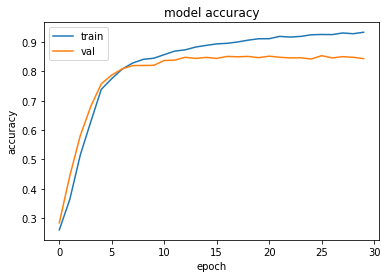

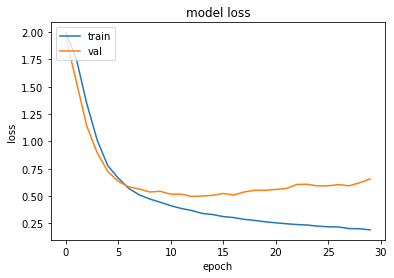

In [55]:
show_plot(train_history)

In [56]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
40/40 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.8422
test loss, test acc: [0.6884962320327759, 0.842157244682312]
Generate predictions for 3 samples
predictions shape: (3, 9)


In [57]:
label_names = ['tào lao', 'ngon', 'dở', 'giá cao', 'giá hợp lý', 
               'vệ sinh sạch sẽ, thực phẩm an toàn', 'vệ sinh bẩn, không đảm bảo', 
               'thái độ phục vụ tốt', 'thái độ phục vụ tệ']

In [58]:
def classify(text):
    toked_sequence = vn_tokenizer(text)
    sequence_without_sw = remove_stopword(toked_sequence, stopword)
    num_sequence = map_word_to_num(sequence_without_sw, vocab)
    padded_sequence = sequence_padding(num_sequence, max_length, 0)
    padded_sequence = np.array(padded_sequence).astype("float32")
    pred = model.predict(padded_sequence)
    classes = [label_names[i] for i in list(pred.argmax(axis=1))]
    return classes

In [59]:
import string
import re
text = ["dở lắm mọi người ơi", "đồ ăn ngon lắm luôn"]
pred = classify(text)
pred

['dở', 'ngon']

In [ ]:
model.save("/content/drive/MyDrive/2021-2022/NLP/Model/transformers3")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/2021-2022/NLP/Model/transformers3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/2021-2022/NLP/Model/transformers3/assets


In [69]:
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(9, activation="softmax")(x)

model2 = Model(inputs=inputs, outputs=outputs)

In [70]:
model2.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=["accuracy"])

train_history2 = model2.fit(x_train, y_train , validation_split=0.2 , batch_size=32 , epochs=30)

Epoch 1/30
296/296 [==============================] - 5s 13ms/step - loss: 1.9917 - accuracy: 0.2661 - val_loss: 1.9416 - val_accuracy: 0.2835
Epoch 2/30
296/296 [==============================] - 3s 12ms/step - loss: 1.5316 - accuracy: 0.4555 - val_loss: 1.1082 - val_accuracy: 0.5942
Epoch 3/30
296/296 [==============================] - 3s 12ms/step - loss: 0.8414 - accuracy: 0.7188 - val_loss: 0.7319 - val_accuracy: 0.7643
Epoch 4/30
296/296 [==============================] - 3s 12ms/step - loss: 0.6459 - accuracy: 0.7836 - val_loss: 0.6090 - val_accuracy: 0.7990
Epoch 5/30
296/296 [==============================] - 3s 12ms/step - loss: 0.5346 - accuracy: 0.8185 - val_loss: 0.5482 - val_accuracy: 0.8172
Epoch 6/30
296/296 [==============================] - 3s 12ms/step - loss: 0.4726 - accuracy: 0.8403 - val_loss: 0.5339 - val_accuracy: 0.8240
Epoch 7/30
296/296 [==============================] - 3s 12ms/step - loss: 0.4300 - accuracy: 0.8537 - val_loss: 0.5357 - val_accuracy: 0.8290

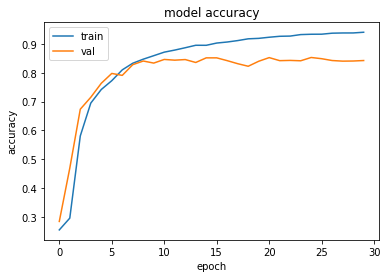

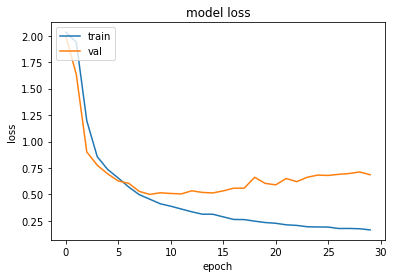

In [62]:
show_plot(train_history2)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model2.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model2.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
40/40 [==============================] - 1s 14ms/step - loss: 0.5934 - accuracy: 0.8420
test loss, test acc: [0.5933986306190491, 0.8419597148895264]
Generate predictions for 3 samples
predictions shape: (3, 9)


In [ ]:
model.save("/content/drive/MyDrive/2021-2022/NLP/Model/transformers4")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/2021-2022/NLP/Model/transformers4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/2021-2022/NLP/Model/transformers4/assets


In [67]:
from keras.initializers import Constant

model=keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 64, input_length=max_length))

model.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv1D(64,3,activation='relu'))
model.add(keras.layers.Conv1D(64,3,activation='relu'))
model.add(keras.layers.MaxPooling1D())

model.add(keras.layers.Conv1D(128,3,activation='relu'))
model.add(keras.layers.MaxPooling1D())

model.add(keras.layers.Conv1D(128,3,activation='relu'))
model.add(keras.layers.MaxPooling1D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dense(9,activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 64)           318528    
                                                                 
 bidirectional_1 (Bidirectio  (None, 120, 512)         657408    
 nal)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 120, 512)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 118, 64)           98368     
                                                                 
 conv1d_5 (Conv1D)           (None, 116, 64)           12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 58, 64)           0         
 1D)                                                  

In [68]:
model.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=["accuracy"])

train_history2 = model.fit(x_train, y_train , validation_split=0.2 , batch_size=32 , epochs=30)

Epoch 1/30
296/296 [==============================] - 13s 24ms/step - loss: 1.9195 - accuracy: 0.2832 - val_loss: 1.6565 - val_accuracy: 0.3847
Epoch 2/30
296/296 [==============================] - 6s 21ms/step - loss: 1.4756 - accuracy: 0.4637 - val_loss: 1.4007 - val_accuracy: 0.4625
Epoch 3/30
296/296 [==============================] - 6s 21ms/step - loss: 1.3234 - accuracy: 0.4915 - val_loss: 1.3251 - val_accuracy: 0.5044
Epoch 4/30
296/296 [==============================] - 6s 21ms/step - loss: 1.2432 - accuracy: 0.5230 - val_loss: 1.2395 - val_accuracy: 0.5277
Epoch 5/30
296/296 [==============================] - 6s 21ms/step - loss: 1.0659 - accuracy: 0.6141 - val_loss: 1.0214 - val_accuracy: 0.6488
Epoch 6/30
296/296 [==============================] - 6s 21ms/step - loss: 0.8161 - accuracy: 0.7262 - val_loss: 0.8619 - val_accuracy: 0.7165
Epoch 7/30
296/296 [==============================] - 6s 21ms/step - loss: 0.7018 - accuracy: 0.7694 - val_loss: 0.8036 - val_accuracy: 0.748